# Классификация изображений по активности людей, архитектура ResNet

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

folder_path = "/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/"

url_jpg_test = [os.path.join(folder_path + "img_test/", entry) for entry in os.listdir(folder_path + "img_test/")]
url_jpg_train = [os.path.join(folder_path + "img_train/", entry) for entry in os.listdir(folder_path + "img_train/")]
url_csv = [os.path.join(folder_path, entry) for entry in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, entry))]

url_csv

['/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/activity_categories.csv',
 '/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/train_answers.csv']

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import ignite
from PIL import Image

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train/6274.jpg
/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train/16481.jpg
/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train/16927.jpg
/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train/6229.jpg


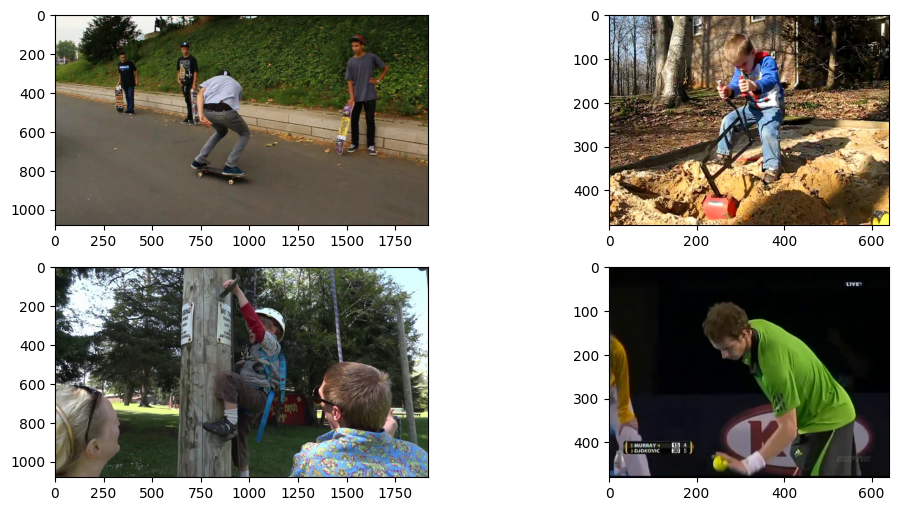

In [4]:
plt.figure(figsize=(12, 6))
for i in range(4):
    rand = np.random.randint(0, 1000)
    img = Image.open(url_jpg_train[rand])
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    print(url_jpg_train[rand])
plt.show()

In [5]:
categories = pd.read_csv(url_csv[0], index_col="id")
ans = pd.read_csv(url_csv[1])
categories

,category
id,
0,sports
1,inactivity quiet/light
2,miscellaneous
3,occupation
4,water activities
5,home activities
6,lawn and garden
7,religious activities
8,winter activities


In [6]:
ans["target_feature"].value_counts()

target_feature
0     2512
3     1680
9     1223
5      982
6      800
16     753
4      752
8      533
2      530
11     528
12     469
13     442
18     410
10     390
14     228
1      135
Name: count, dtype: int64

In [7]:
sorted(ans["target_feature"].unique()), len(ans["target_feature"].unique())

([0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18], 16)

**сильный дисбаланс по классам, почему то в датасете только 16 классов**

In [8]:
unique_classes = sorted(ans["target_feature"].unique())

label_map = {old_label: new_label for new_label, old_label in enumerate(unique_classes)}
reverse_map = {new_label: old_label for old_label, new_label in label_map.items()}
new_ans = ans.copy()
new_ans["target_feature"] = new_ans["target_feature"].map(label_map)
sorted(new_ans.target_feature.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

**попытка сбалансировать классы неудачная**

In [9]:
# from imblearn.under_sampling import RandomUnderSampler

# # Применяем даунсэмплинг
# rus = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = rus.fit_resample(new_ans[["img_id"]], new_ans['target_feature'])

# new_ans = pd.concat((X_resampled, y_resampled), axis=1)
# new_ans["target_feature"].value_counts()

In [10]:
from torch.utils.data import Dataset

PATH_TEST = "/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_test/"
PATH_TRAIN = "/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train/"

class ImgDataset(Dataset):
    def __init__(self, ind_labels, path, transform=None):
        self.ind_labels = ind_labels
        self.path = path
        self.transform = transform
                
    def __len__(self):
        return len(self.ind_labels)

    def __getitem__(self, idx):
        img, y = self.ind_labels[idx]
        image = Image.open(self.path + str(img) + ".jpg")
        
        if self.transform != None:
            x = self.transform(image)
        
        image.close()

        return x, y

In [11]:
from torchvision.transforms import ToTensor, Compose, Resize, CenterCrop, Normalize
from torchvision import transforms

BaseTransform = Compose([
    Resize(380),
    CenterCrop(356),
    ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augTransform = Compose([
    Resize(324),
    CenterCrop(300),
    transforms.RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

aug2Transform = transforms.Compose([
    Resize(380),
    transforms.RandomResizedCrop(356),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_size = int(len(new_ans.values) * 0.8)

In [12]:
from torch.utils.data import DataLoader, random_split

new_ans = new_ans.sample(frac=1)

train_dataset = ImgDataset(new_ans.values[:train_size], PATH_TRAIN, aug2Transform)
valid_dataset = ImgDataset(new_ans.values[train_size:], PATH_TRAIN, BaseTransform)

train_dataloader = DataLoader(train_dataset,
                              batch_size=16,
                              num_workers=4,
                              pin_memory=True)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=16,
                              num_workers=4,
                              pin_memory=True)

In [13]:
len(train_dataset), len(valid_dataset)

(9893, 2474)

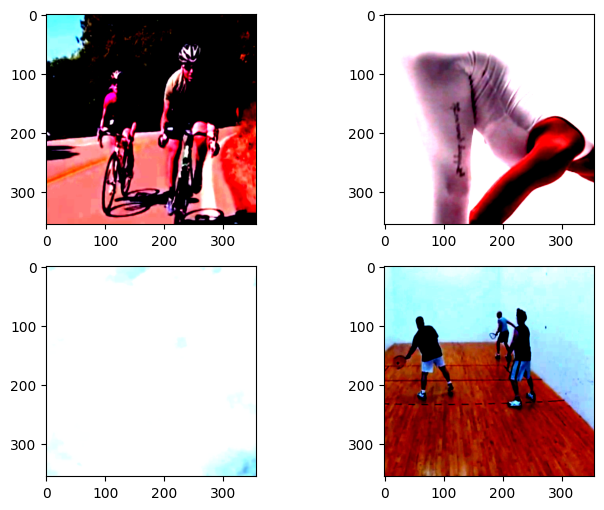

In [14]:
plt.figure(figsize=(8, 6))
for i in range(4):
    rand = np.random.randint(0, len(train_dataset))
    plt.subplot(2, 2, i + 1)
    plt.imshow(train_dataset[rand][0].permute(1,2,0))
plt.show()

In [15]:
from torch import nn

class Block2d(nn.Module):
    def __init__(self, in_size=8, out_size=8, stride=1, act_func="relu"):
        super().__init__()
        funcs = {
            "relu": nn.ReLU(),
            "leaky": nn.LeakyReLU(),
            "gelu": nn.GELU()
        }

        self.seq = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_size),
            funcs[act_func],
            nn.Dropout(0.2),
            nn.Conv2d(out_size, out_size, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_size),
            funcs[act_func]
        )
        self.shortcut = nn.Sequential()
        self.shortcut.add_module("conv1x1", nn.Conv2d(in_size, out_size, kernel_size=1, stride=stride))
    
    def forward(self, x):
        residual = self.shortcut(x)
        out = self.seq(x)
        out = out + residual
        return out


class Classificator(nn.Module):
    def __init__(self, in_size, hide_size, out_size=16):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_size, hide_size),
            nn.BatchNorm1d(hide_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hide_size, hide_size // 2),
            nn.ReLU(),
            nn.Linear(hide_size // 2, out_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.seq(x)


class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.short_cut_blocks = nn.Sequential(
            Block2d(3, 64, act_func="leaky"),
            Block2d(64, 64, 2),
            Block2d(64, 64, 2),
            Block2d(64, 64, 2),
            Block2d(64, 64, 2, act_func="leaky"),
            Block2d(64, 32, 2, act_func="leaky")
        )
        self.conv_seq = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.flat = nn.Flatten(-3)
        self.classificator1 = Classificator(512, 1000)

    def forward(self, x):
        out = self.short_cut_blocks(x)
        conv_res = self.conv_seq(out)
        flat_conv_res = self.flat(conv_res)
        out = self.classificator1(flat_conv_res)

        return out

In [16]:
from torchsummary import summary

model_v1 = Model1().to(device)
summary(model_v1, input_size=(3, 324, 324))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 324, 324]             256
            Conv2d-2         [-1, 64, 324, 324]           1,792
       BatchNorm2d-3         [-1, 64, 324, 324]             128
         LeakyReLU-4         [-1, 64, 324, 324]               0
           Dropout-5         [-1, 64, 324, 324]               0
            Conv2d-6         [-1, 64, 324, 324]          36,928
       BatchNorm2d-7         [-1, 64, 324, 324]             128
         LeakyReLU-8         [-1, 64, 324, 324]               0
           Block2d-9         [-1, 64, 324, 324]               0
           Conv2d-10         [-1, 64, 162, 162]           4,160
           Conv2d-11         [-1, 64, 324, 324]          36,928
      BatchNorm2d-12         [-1, 64, 324, 324]             128
             ReLU-13         [-1, 64, 324, 324]               0
          Dropout-14         [-1, 64, 3

In [17]:
import torch.nn.functional as F

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            
            nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels*self.expansion)
        )
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels*self.expansion:
            self.shortcut.add_module("conv1x1",
                nn.Conv2d(in_channels, out_channels*self.expansion, 
                          kernel_size=1, stride=stride, bias=False))
            self.shortcut.add_module("batchnorm", nn.BatchNorm2d(out_channels*self.expansion))

    def forward(self, x):
        out = self.conv_layer(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet300(nn.Module):
    def __init__(self, num_classes=16):
        super().__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Layers
        self.layer1 = self._make_layer(Bottleneck, 64, 3, stride=1)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = [block(self.in_channels, out_channels, stride)]
        
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, stride=1))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)                   
        
        x = self.layer1(x)                    
        x = self.layer2(x)                    
        x = self.layer3(x)                   
        x = self.layer4(x)                   
        
        x = self.avgpool(x)    
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [18]:
model_v2 = ResNet300().to(device)
summary(model_v2, (3, 356, 356))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 178, 178]           9,408
       BatchNorm2d-2         [-1, 64, 178, 178]             128
         MaxPool2d-3           [-1, 64, 89, 89]               0
            Conv2d-4           [-1, 64, 89, 89]           4,096
       BatchNorm2d-5           [-1, 64, 89, 89]             128
            Conv2d-6           [-1, 64, 89, 89]          36,864
       BatchNorm2d-7           [-1, 64, 89, 89]             128
            Conv2d-8          [-1, 256, 89, 89]          16,384
       BatchNorm2d-9          [-1, 256, 89, 89]             512
           Conv2d-10          [-1, 256, 89, 89]          16,384
      BatchNorm2d-11          [-1, 256, 89, 89]             512
       Bottleneck-12          [-1, 256, 89, 89]               0
           Conv2d-13           [-1, 64, 89, 89]          16,384
      BatchNorm2d-14           [-1, 64,

In [19]:
uniqs_class = set()

In [20]:
from torchmetrics import Accuracy, F1Score
from torch import optim

def train(model, train_dataloader, valid_dataloader, criterion, optimizer):
    train_sum = 0
    model.train()
    for data, target in train_dataloader:
        data = data.to(device)
        target = target.to(device)
        pred = model(data)
        loss = criterion(pred, target)
        train_sum += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    valid_loss, valid_accuracy = 0, 0
    valid_f1score_macro, valid_f1score_weighted = 0, 0
    for data, target in valid_dataloader:
        data = data.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            proba = model(data)
            pred = torch.argmax(proba, dim=1)
            
            for i in pred.tolist():
                uniqs_class.add(i)
                
            valid_loss += criterion(proba, target).item()
            valid_accuracy += Accuracy("MULTICLASS", num_classes=20).to(device)(pred, target).item()
            valid_f1score_macro += F1Score("MULTICLASS", num_classes=20, average="macro").to(device)(pred, target).item()
            valid_f1score_weighted += F1Score("MULTICLASS", num_classes=20, average="weighted").to(device)(pred, target).item()
        
    
    return train_sum / len(train_dataloader), valid_loss / len(valid_dataloader), valid_accuracy / len(valid_dataloader), valid_f1score_macro / len(valid_dataloader), valid_f1score_weighted / len(valid_dataloader)

In [21]:
#os.remove("/kaggle/working/resnet_best.pth")

In [22]:
model_epoch = 0
model_file = "resnet_best.pth"

if model_file in os.listdir("/kaggle/working/"):
    model_v2.load_state_dict(torch.load("/kaggle/working/" + model_file, weights_only=True, map_location=device))
    with open("/kaggle/working/bestmodel_info.txt", "r") as f:
        model_epoch = int(f.read())
        print("model loaded, epoch ", model_epoch)

model loaded, epoch  5


**надо поработать над адамом, сделать sсheduler и поработать на lr**

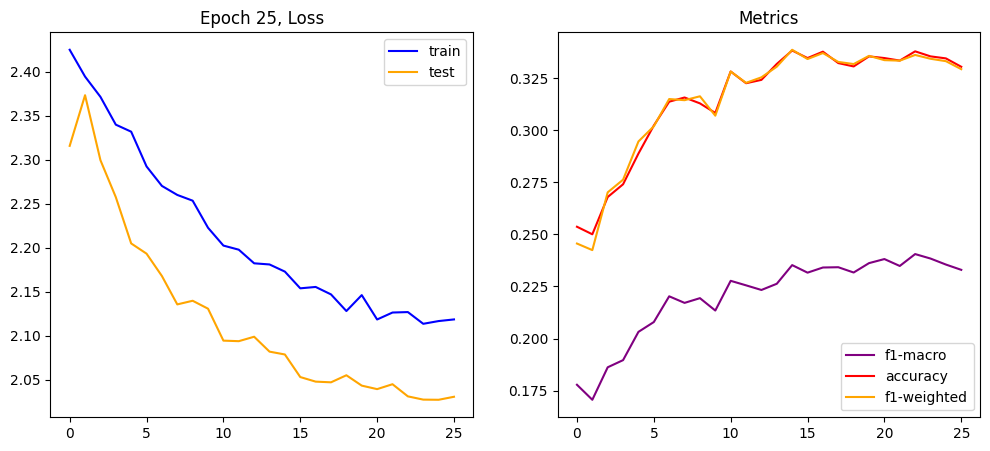

Epoch: 25, 2.1184185837697904, 2.0305766874744045, 0.33056451620594146, 0.23300266030334657 time: 3.055m
Epoch: 26, 2.1121456796402693, 2.0265529117276593, 0.3327419355030983, 0.23720923551628667 time: 3.14m
Epoch: 27, 2.1064121923462062, 2.0229378108055363, 0.3293548387865866, 0.2318139071065572 time: 3.073m
Epoch: 28, 2.118353078554058, 2.02671745592548, 0.33620967749626407, 0.2370638387578149 time: 3.366m
Epoch: 29, 2.121138934942748, 2.021560099047999, 0.32895161298013503, 0.2302148302235911 time: 3.312m


In [ ]:
from IPython.display import clear_output
from time import time
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import StepLR, LambdaLR


epoch = 100
train_losses, valid_losses, valid_accuracy = [], [], []
valid_f1score, valid_f1score_w = [], []

class_weights = torch.tensor(compute_class_weight(
    class_weight="balanced",
    classes=np.unique(new_ans["target_feature"].values), 
    y=new_ans["target_feature"].values
), dtype=torch.float32).to(device)
print(class_weights)
crit = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_v2.parameters(), 0.01)
#scheduler = StepLR(optimizer, step_size=2, gamma=0.5)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.85 ** epoch)

best_epoch = model_epoch
best_f1score = 0

for ep in range(0, epoch + 1):
    start_time = time()
    train_loss, valid_loss, valid_acc, valid_f1, valid_f1_w = train(model_v2, train_dataloader, valid_dataloader, crit, optimizer)
    scheduler.step(ep + 1)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracy.append(valid_acc)
    valid_f1score.append(valid_f1)
    valid_f1score_w.append(valid_f1_w)

    if valid_f1 > best_f1score:
        best_f1score = valid_f1
        with open("/kaggle/working/bestmodel_info.txt", "w") as f:
            best_epoch = ep
            f.write(str(ep))
        torch.save(model_v2.state_dict(), model_file)
    
    if ep % 5 == 0:
        clear_output()
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, color="blue", label="train")
        plt.plot(valid_losses, color="orange", label="test")
        plt.title(f"Epoch {ep}, Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(valid_f1score, color="purple", label="f1-macro")
        plt.plot(valid_accuracy, color="red", label="accuracy")
        plt.plot(valid_f1score_w, color="orange", label="f1-weighted")
        plt.title(f"Metrics")
        plt.legend()
        
        plt.show()

    print(f"Epoch: {ep}, {train_loss}, {valid_loss}, {valid_acc}, {valid_f1} time: {round((time() - start_time) / 60, 3)}m")

In [ ]:
class TestImgDataset(Dataset):
    def __init__(self, dirlist, transform=None):
        self.dirlist = dirlist
        self.transform = transform
                
    def __len__(self):
        return len(self.dirlist)

    def __getitem__(self, idx):
        image = Image.open(self.dirlist[idx])
        ids = self.dirlist[idx].split("/")[-1].split('.')[0]
        
        if self.transform != None:
            x = self.transform(image)
        
        image.close()

        return x, ids

test_dataset = TestImgDataset(url_jpg_test, BaseTransform)
test_dataloader = DataLoader(test_dataset,
                              batch_size=16,
                              num_workers=4,
                              pin_memory=True)

In [ ]:
test_answers = pd.DataFrame()

ids_test = []
target_test = []

for img, ids in test_dataloader:
    img = img.to(device)
    pred = model_v2(img)
    target = [reverse_map[i] for i in torch.argmax(pred, dim=1).tolist()]
    target_test.extend(target)
    ids_test.extend(ids)

test_answers["id"] = ids_test
test_answers["target_feature"] = target_test
test_answers

In [ ]:
sorted(test_answers.target_feature.unique())

In [ ]:
test_answers.to_csv("/kaggle/working/submission.csv", index=False)

In [ ]:
# from torchvision.models import resnet50, ResNet50_Weights

# pretrainde_resnet = resnet50(weights=ResNet50_Weights.DEFAULT)